#### IMPORTS

In [271]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from typing import NamedTuple
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.losses import SparseCategoricalCrossentropy
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.python.keras.activations import relu, softmax
# ??? from tensorflow.python.keras.optimizers import gradient_descent_v2

#### PARAMS

In [272]:
ACTIVATION_DENSE = softmax
ACTIVATION_CONV2D = relu
LOSS = SparseCategoricalCrossentropy()
OPTIMIZER = 'adam'
METRICS = ['accuracy']
SHAPE = (28, 28, 1)
EPOCHS = 1
GET_DATA = {
    "mnist": lambda: tf.keras.datasets.mnist.load_data(path="mnist.npz"),
    "fashion_mnist": lambda: tf.keras.datasets.fashion_mnist.load_data(),
}
LABELS_FASHION_MNIST = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
N_CLASSES = len(LABELS_FASHION_MNIST)

#### HELP CLASSES

In [273]:
class Data(NamedTuple):
    x_train: np.ndarray
    y_train: np.ndarray
    x_test: np.ndarray
    y_test: np.ndarray


#### DATA

In [274]:
def get_data(type_data: str) -> Data:
    def convert(x: np.ndarray):
        return np.expand_dims(np.array(x, dtype="float32"), -1)

    (x_train, y_train), (x_test, y_test) = GET_DATA[type_data]()
    return Data(convert(x_train), y_train, convert(x_test), y_test)


#### BEST PARAMS

In [275]:
def check_with_params(n_filters, data):
    print("Filters: %d" % n_filters)
    x_train, y_train, x_test, y_test = data
    model = build_model(n_filters)
    model.fit(x_train, y_train, epochs=EPOCHS, verbose=1, validation_data=(x_test, y_test))
    _, accuracy = model.evaluate(data.x_test, data.y_test, verbose=0)
    return accuracy


def get_best_params():
    data = get_data("mnist")
    return max(range(16, 33, 8), key=lambda n_filters: check_with_params(n_filters, data))

#### MODEL

In [276]:
def build_model(n_filters) -> Sequential:
    model = tf.keras.Sequential([
        Conv2D(n_filters, kernel_size=3, activation=ACTIVATION_CONV2D, input_shape=SHAPE),
        MaxPooling2D(),
        Conv2D(2 * n_filters, kernel_size=2, activation=ACTIVATION_CONV2D),
        MaxPooling2D(),
        Flatten(),
        Dense(N_CLASSES, activation=ACTIVATION_DENSE),
    ])
    model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)
    return model

#### DRAW

In [277]:
def draw_matrix(y_true, y_pred):
    display = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=LABELS_FASHION_MNIST)
    display.plot(ax=plt.figure(figsize=(14, 9)).add_subplot())
    plt.show()


def draw_images(x, y_true, predicts):
    probabilities, res = np.zeros((N_CLASSES, N_CLASSES)), np.zeros((N_CLASSES, N_CLASSES), dtype=int)
    for i in range(len(predicts)):
        class_i = y_true[i]
        for class_j, probability in enumerate(predicts[i]):
            if probability > probabilities[class_i][class_j]:
                probabilities[class_i][class_j] = probability
                res[class_i][class_j] = i

    fig = plt.figure(figsize=(N_CLASSES, N_CLASSES))
    ax = fig.add_subplot()
    ax.set(xticks=np.arange(N_CLASSES),
           yticks=np.arange(N_CLASSES),
           xticklabels=LABELS_FASHION_MNIST,
           yticklabels=LABELS_FASHION_MNIST)
    ax.set_ylim((N_CLASSES - 0.5, -0.5))

    for i in range(N_CLASSES ** 2):
        fig.add_subplot(N_CLASSES, N_CLASSES, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(x[res[i // N_CLASSES][i % N_CLASSES]], cmap=plt.cm.binary)
    plt.show()

#### MAIN

Filters: 16
1875/1875 [==============================] - 10s 5ms/step - loss: 0.7489 - accuracy: 0.9217 - val_loss: 0.1168 - val_accuracy: 0.9654

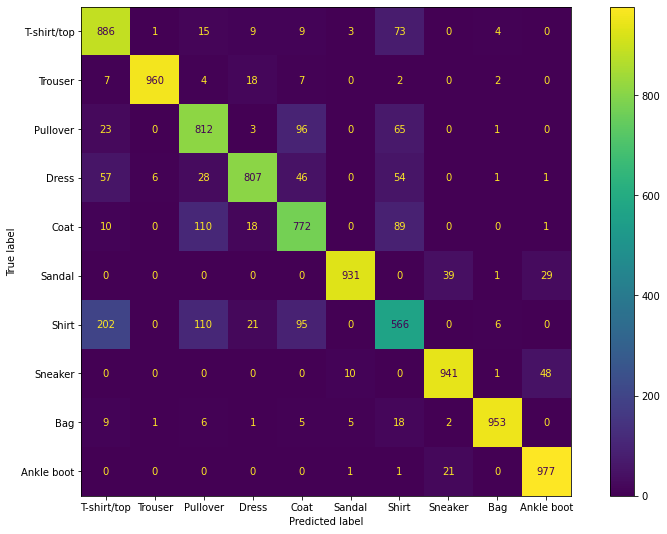

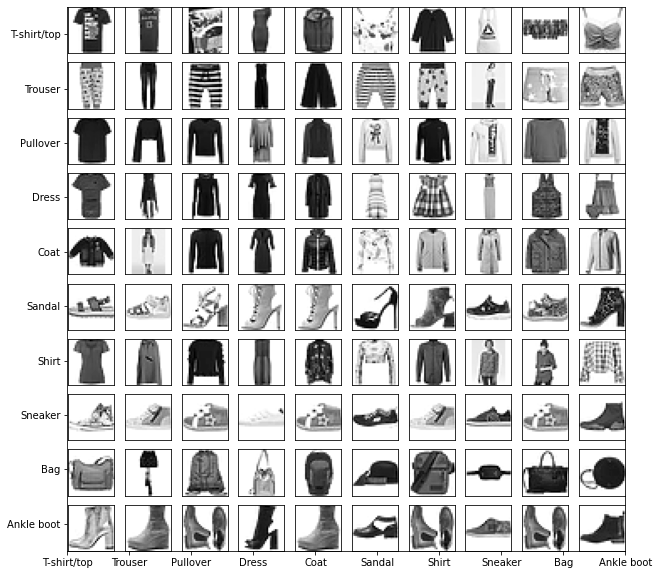

In [278]:
def main():
    n_filters = get_best_params()
    model = build_model(n_filters)
    print("Best %s" % str(n_filters))

    x_train, y_train, x_test, y_test = get_data("fashion_mnist")
    model.fit(x_train, y_train, epochs=EPOCHS, verbose=1, validation_data=(x_test, y_test))
    predicts = model.predict(x_test)

    y_pred = np.argmax(predicts, axis=-1)
    print("Accuracy: %f" % accuracy_score(y_test, y_pred))

    draw_matrix(y_test, y_pred)
    draw_images(x_test, y_test, predicts)


if __name__ == '__main__':
    main()